# Final Test-Set Evaluation Notebook

In [1]:
# Imports
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import time

## Loading in Training Data

The following code chunk uses polars to load in the training dataset. It then splits the data into X (features) and y (labels) numpy arrays. LabelEncoder is then used to convert the string labels into integers for model training. The shape of the resulting arrays is printed, along with the classes and their corresponding integer labels.

In [2]:
# Loading in training data
data = pl.read_parquet('../data/training_data.parquet')

# Splitting features and labels
X_train = data.drop("label").to_numpy()
y_train = data["label"].to_numpy()

# Encoding labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Displaying shapes and encoder mapping
print("TRAINING DATA:\n")
print(f"Features shape: {X_train.shape}, Labels shape: {y_train_encoded.shape}\n")
print("Classes:")
for i, class_label in enumerate(encoder.classes_):
    print(f"{i} -> {class_label}")

TRAINING DATA:

Features shape: (68250, 785), Labels shape: (68250,)

Classes:
0 -> airplane
1 -> ice cream
2 -> spreadsheet
3 -> sword


## Training the Final Model

The following code chunk uses _ from sklearn to train a _ model on the full training data. The optimal model and hyperparameters is used to traing the model, and the time taken for training is printed.

In [ ]:
# Train Final Model Here

"""
model = INSET BEST MODEL HERE

# Fitting the model and timing the time to fit
train_start = time.time()
model.fit(X_train, y_train_encoded)
train_end = time.time()
train_diff = train_end - train_start

# Printing at completion of training
print("Final Model Training Complete")
print(f"Time to train Final Model: {np.round(train_diff, 2)} seconds")
"""

Final Model Training Complete
Time to train Final Model: 34.42 seconds


## Loading in Testing Data

The following code chunk uses polars to load in the testing dataset. It then splits the data into X (features) and y (labels) numpy arrays. LabelEncoder is then used to convert the string labels into integers for evaluation. The shape of the resulting arrays is printed, along with the classes and their corresponding integer labels.

In [4]:
# Loading in testing data
data = pl.read_parquet('../data/testing_data.parquet')

# Splitting features and labels
X_test = data.drop("label").to_numpy()
y_test = data["label"].to_numpy()

# Encoding labels using the same encoding as the training data to ensure classes match correctly
y_test_encoded = encoder.transform(y_test)

# Displaying shapes and encoder mapping
print("TESTING DATA:\n")
print(f"Features shape: {X_test.shape}, Labels shape: {y_test_encoded.shape}\n")
print("Classes:")
for i, class_label in enumerate(encoder.classes_):
    print(f"{i} -> {class_label}")

TESTING DATA:

Features shape: (17063, 785), Labels shape: (17063,)

Classes:
0 -> airplane
1 -> ice cream
2 -> spreadsheet
3 -> sword


## Evaluating Final Model on Testing Data

The following code uses the trained best model to make prediction on the test set. These predictions are then used to calculate the accuracy, and visualize a confusion matrix for the best model.

In [ ]:
# Predicting on the Test Data

# y_pred = model.predict(X_test)

In [ ]:
# Calculating and Printing the Test Accuracy

# test_accuracy = accuracy_score(y_test_encoded, y_pred)
# print(f"Final Model Testing Accuracy: {test_accuracy:.4f}")

Final Model Testing Accuracy: 0.9554


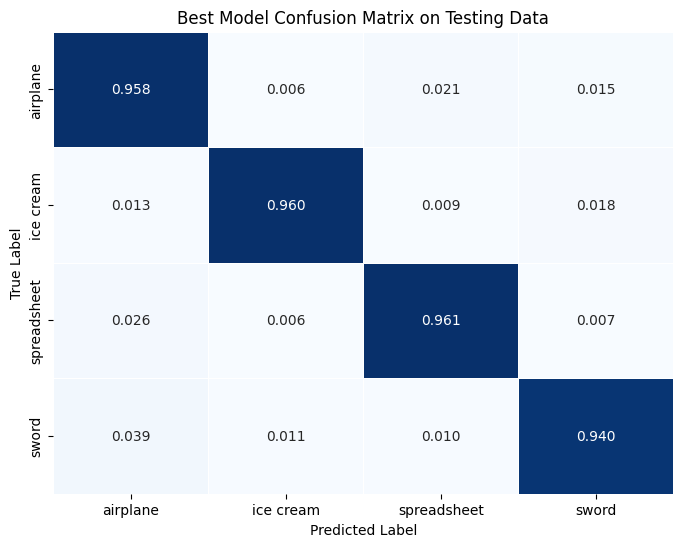

In [ ]:
# Visualizing Confusion Matrix of Best Model

"""
# Create a confusion matrix using the best model's predictions
    # Normalized due to non-uniform distribution of classes
cm = confusion_matrix(y_test_encoded, y_pred, normalize = 'true')

# Initialize figure
plt.figure(figsize = (8, 6))

# Plot confusion matrix
sns.heatmap(
    cm,
    annot = True,
    fmt = '.3f',
    cmap = 'Blues',
    linewidth = 0.5,
    cbar = False,
    xticklabels = encoder.classes_,
    yticklabels = encoder.classes_
)

plt.title("Best Model Confusion Matrix on Testing Data")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("../output/Final_Model_ConfusionMatrix.png")
plt.show()
"""